### Clustering - Toronto neighbors

In [1]:
import numpy as np # library to handle data in a vectorized manner
from IPython.display import Image

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## 1. Obtaining the data - Wikipedia

In [2]:
toronto = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]

toronto = toronto.loc[toronto.Borough != 'Not assigned'] # Removing 'Not Assigned' Boroughs

toronto.head()

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [3]:
print('Dimensions: ' , toronto.shape, '; \n'
      'Neighbors Not Assigned: ', toronto.loc[toronto.Neighborhood == 'Not Assigned'].shape[0])

Dimensions:  (103, 3) ; 
Neighbors Not Assigned:  0


## 2. Obtaining lat / long coordinates

In [4]:
lat_long = pd.read_csv('http://cocl.us/Geospatial_data') # Provided link to lat/long data

toronto = pd.merge(toronto, lat_long, on = 'Postal Code')

print('Dimensions: ',toronto.shape)
toronto.head()

Dimensions:  (103, 5)


,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


## 3. Exploring Toronto's Neighborhoods

In [5]:
address = 'Toronto City, Ontario'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.6534817, -79.3839347.


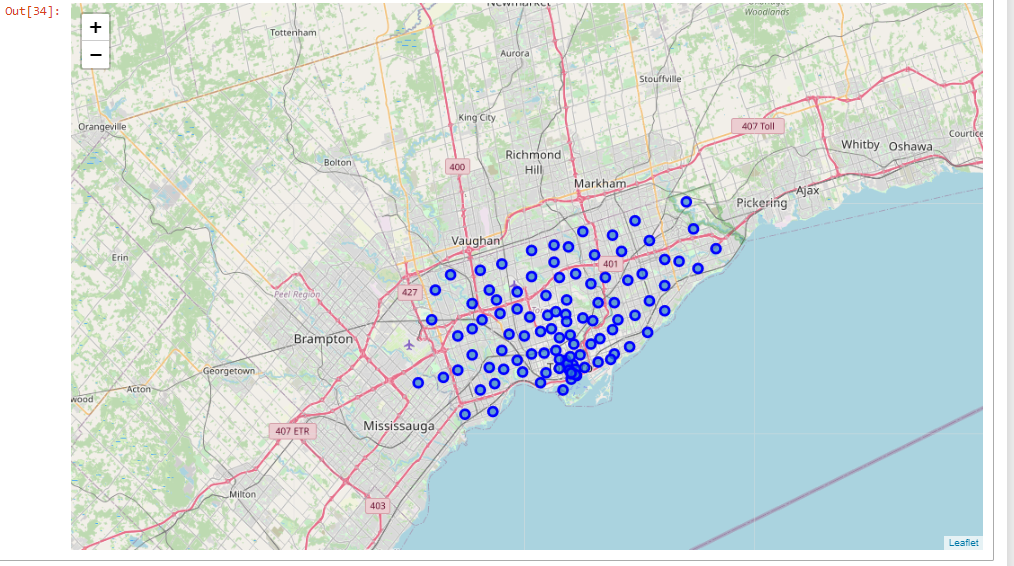

In [35]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto['Latitude'], toronto['Longitude'], toronto['Borough'], toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
Image('C:/Users/elton.junior/Downloads/IBM_Coursera/map_toronto.png')# Github don't render folium map

## 4. Extracting North York's information

We are going to analyse the North York's neighborhood

In [7]:
northy_data = toronto[toronto['Borough'] == 'North York'].reset_index(drop=True)
print(northy_data.shape)
northy_data.head()

(24, 5)


,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
3,M3B,North York,Don Mills,43.745906,-79.352188
4,M6B,North York,Glencairn,43.709577,-79.445073


In [8]:
address = 'North York, Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Noth York are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Noth York are 43.7543263, -79.44911696639593.


In [9]:
CLIENT_ID = 'JTJG0JSV3AX5DOIOMYGJJYWRSOY0IWCVLHJKH32N3QVC4UU0' # your Foursquare ID
CLIENT_SECRET = 'XLNPRZEDPL2MMXTAVDQZVOEM5L2MLTOFIIZPEKWD1U2I0MJF' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#### Now, let's get the top 80 venues that are in North York within a radius of 500 meters.

In [10]:
LIMIT = 80 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=JTJG0JSV3AX5DOIOMYGJJYWRSOY0IWCVLHJKH32N3QVC4UU0&client_secret=XLNPRZEDPL2MMXTAVDQZVOEM5L2MLTOFIIZPEKWD1U2I0MJF&v=20180605&ll=43.7543263,-79.44911696639593&radius=500&limit=80'

In [11]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [12]:
northy_venues = getNearbyVenues(names=northy_data['Neighborhood'],
                                   latitudes=northy_data['Latitude'],
                                   longitudes=northy_data['Longitude']
                                  )


Parkwoods
Victoria Village
Lawrence Manor, Lawrence Heights
Don Mills
Glencairn
Don Mills
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Fairview, Henry Farm, Oriole
Northwood Park, York University
Bayview Village
Downsview
York Mills, Silver Hills
Downsview
North Park, Maple Leaf Park, Upwood Park
Humber Summit
Willowdale, Newtonbrook
Downsview
Bedford Park, Lawrence Manor East
Humberlea, Emery
Willowdale, Willowdale East
Downsview
York Mills West
Willowdale, Willowdale West


#### Let's check the size of the resulting dataframe

In [13]:
print(northy_venues.shape)
northy_venues.head()

(244, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


Let's check how many venues were returned for each neighborhood

In [14]:
northy_venues.groupby('Neighborhood').count()['Venue']

Neighborhood
Bathurst Manor, Wilson Heights, Downsview North    21
Bayview Village                                     4
Bedford Park, Lawrence Manor East                  23
Don Mills                                          27
Downsview                                          18
Fairview, Henry Farm, Oriole                       64
Glencairn                                           4
Hillcrest Village                                   5
Humber Summit                                       1
Humberlea, Emery                                    2
Lawrence Manor, Lawrence Heights                   13
North Park, Maple Leaf Park, Upwood Park            3
Northwood Park, York University                     6
Parkwoods                                           2
Victoria Village                                    5
Willowdale, Newtonbrook                             1
Willowdale, Willowdale East                        34
Willowdale, Willowdale West                         7
York Mills West

In [15]:
# one hot encoding
northy_onehot = pd.get_dummies(northy_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
northy_onehot['Neighborhood'] = northy_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [northy_onehot.columns[-1]] + list(northy_onehot.columns[:-1])
northy_onehot = northy_onehot[fixed_columns]

northy_onehot.head()

,Neighborhood,Accessories Store,Airport,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bakery,Bank,Bar,Baseball Field,Beer Store,Bike Shop,Boutique,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Butcher,Cafeteria,Café,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Electronics Store,Event Space,Fast Food Restaurant,Financial or Legal Service,Food & Drink Shop,Food Court,Food Truck,Fried Chicken Joint,Furniture / Home Store,Gas Station,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hockey Arena,Home Service,Hotel,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Liquor Store,Lounge,Luggage Store,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Metro Station,Middle Eastern Restaurant,Miscellaneous Shop,Movie Theater,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Piano Bar,Pizza Place,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Restaurant,Salon / Barbershop,Sandwich Place,Shoe Store,Shopping Mall,Snack Place,Spa,Sporting Goods Shop,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Video Game Store,Video Store,Vietnamese Restaurant,Women's Store
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
northy_grouped = northy_onehot.groupby('Neighborhood').mean().reset_index()

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = northy_grouped['Neighborhood']

for ind in np.arange(northy_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(northy_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Pet Store,Bridal Shop,Diner
1,Bayview Village,Chinese Restaurant,Café,Bank,Japanese Restaurant,Women's Store
2,"Bedford Park, Lawrence Manor East",Sandwich Place,Sushi Restaurant,Restaurant,Italian Restaurant,Coffee Shop
3,Don Mills,Gym,Japanese Restaurant,Asian Restaurant,Coffee Shop,Restaurant
4,Downsview,Grocery Store,Park,Gym / Fitness Center,Korean Restaurant,Discount Store
5,"Fairview, Henry Farm, Oriole",Clothing Store,Coffee Shop,Women's Store,Fast Food Restaurant,Japanese Restaurant
6,Glencairn,Playground,Pub,Bakery,Japanese Restaurant,Women's Store
7,Hillcrest Village,Golf Course,Pool,Athletics & Sports,Mediterranean Restaurant,Dog Run
8,Humber Summit,Shopping Mall,Women's Store,Electronics Store,Comfort Food Restaurant,Construction & Landscaping
9,"Humberlea, Emery",Paper / Office Supplies Store,Baseball Field,Women's Store,Event Space,Construction & Landscaping


## 5. Cluster Neighborhoods

In [17]:
# set number of clusters
kclusters = 2

northy_grouped_clustering = northy_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(northy_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [18]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
northy_final = northy_data.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
northy_final.drop('Postal Code', axis = 1,  inplace = True)

northy_final.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,North York,Parkwoods,43.753259,-79.329656,0,Park,Food & Drink Shop,Women's Store,Electronics Store,Construction & Landscaping
1,North York,Victoria Village,43.725882,-79.315572,0,Hockey Arena,Portuguese Restaurant,Intersection,Financial or Legal Service,Coffee Shop
2,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0,Clothing Store,Furniture / Home Store,Accessories Store,Boutique,Gift Shop
3,North York,Don Mills,43.745906,-79.352188,0,Gym,Japanese Restaurant,Asian Restaurant,Coffee Shop,Restaurant
4,North York,Glencairn,43.709577,-79.445073,0,Playground,Pub,Bakery,Japanese Restaurant,Women's Store


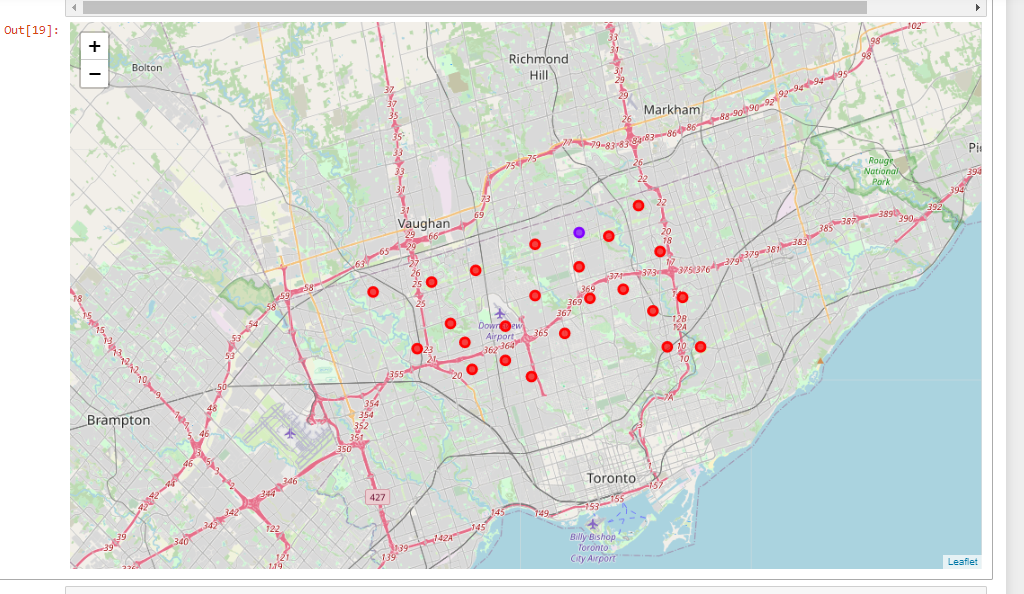

In [33]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(northy_final['Latitude'], northy_final['Longitude'], northy_final['Neighborhood'], northy_final['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
Image('C:/Users/elton.junior/Downloads/IBM_Coursera/map_cluster.png')# Github don't render folium map

There's only one neighboor isolated which indicates that, in general, this neighborhoods is homogenous